## 00. Imports

In [8]:
import cv2
import numpy as np
import rawpy
import matplotlib.pyplot as plt

## 01. Import photos

In [16]:
import requests
from bs4 import BeautifulSoup
from PIL import Image
from io import BytesIO

# URL of the shared folder
folder_url = "https://epflch-my.sharepoint.com/personal/ewa_miazga_epfl_ch/Documents/first_dataset_JPG"

# Function to download and load an image
def load_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return img

# Scrape the folder page to get image URLs
response = requests.get(folder_url)
soup = BeautifulSoup(response.content, 'html.parser')

# Find all image links (assuming they are <a> tags with href attributes)
image_urls = []
for link in soup.find_all('a', href=True):
    href = link['href']
    if href.endswith('.jpg') or href.endswith('.jpeg') or href.endswith('.png'):
        image_urls.append(href)

# Load and display images
for url in image_urls:
    image = load_image(url)
    image.show()

print(len(image_urls), "images found") 

0 images found


In [20]:
!wget -r -np -nH --cut-dirs=3 -R "index.html*" "https://epflch-my.sharepoint.com/personal/ewa_miazga_epfl_ch/Documents/first_dataset_JPG/"

import os
from PIL import Image

# Path to the local directory where images are downloaded
local_folder_path = "./first_dataset_JPG"

# Function to load and display images
def load_and_display_images(folder_path):
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
            image_path = os.path.join(folder_path, filename)
            img = Image.open(image_path)
            img.show()

# Load and display images
load_and_display_images(local_folder_path)

'wget' is not recognized as an internal or external command,
operable program or batch file.


FileNotFoundError: [WinError 3] The system cannot find the path specified: './first_dataset_JPG'

## 01. RANSAC on RAW photos

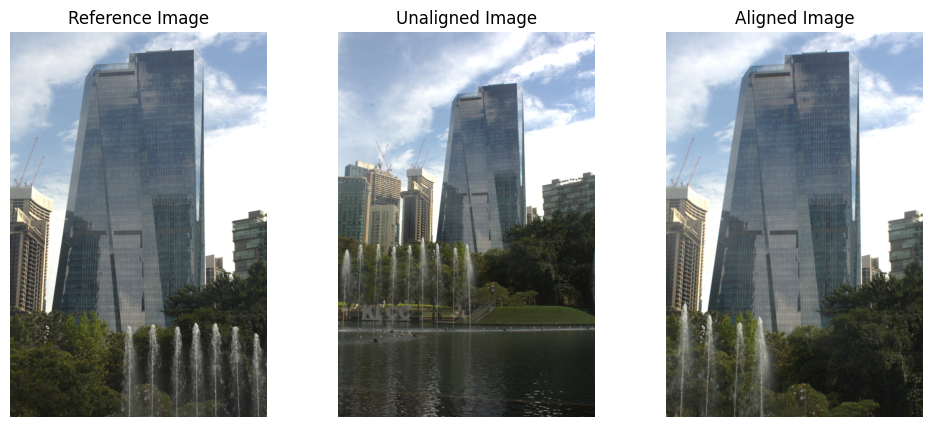

In [11]:
import cv2
import numpy as np
import rawpy
import matplotlib.pyplot as plt

def read_image(filename):
    """Reads an image in full color. Supports RAW and JPG/PNG formats."""
    if filename.lower().endswith(('.nef', '.cr2', '.arw', '.dng', '.rw2')):  # RAW formats
        with rawpy.imread(filename) as raw:
            rgb = raw.postprocess()  # Process RAW file to RGB
        image = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)  # Convert to OpenCV BGR format
    else:  # JPG/PNG
        image = cv2.imread(filename)
    
    if image is None:
        raise ValueError(f"Failed to read image: {filename}")
    
    return image

def align_images(img1, img2):
    """Aligns img2 to img1 using ORB feature matching and RANSAC."""
    orb = cv2.ORB_create(5000)

    # Convert images to grayscale for feature detection
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Detect keypoints and descriptors
    kp1, des1 = orb.detectAndCompute(img1_gray, None)
    kp2, des2 = orb.detectAndCompute(img2_gray, None)

    # Match features using BFMatcher
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)  # Sort by distance

    # Use RANSAC to find homography
    if len(matches) > 10:
        src_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
        
        H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        
        # Warp img2 to align with img1 (preserving colors)
        aligned_img = cv2.warpPerspective(img2, H, (img1.shape[1], img1.shape[0]))
        
        return aligned_img, H
    else:
        raise ValueError("Not enough matches found.")

# Example usage
DIR = "first-dataset-RAW/"
image1_path = f"{DIR}IMG_7781.CR2"  # Change to your RAW/JPG file path
image2_path = f"{DIR}IMG_7782.CR2"  # Change to your RAW/JPG file path

img1 = read_image(image1_path)
img2 = read_image(image2_path)

aligned_img, homography = align_images(img1, img2)

# Convert BGR to RGB for correct color display in Matplotlib
img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
aligned_img_rgb = cv2.cvtColor(aligned_img, cv2.COLOR_BGR2RGB)

# Show results
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.imshow(img1_rgb)
plt.title("Reference Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img2_rgb)
plt.title("Unaligned Image")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(aligned_img_rgb)
plt.title("Aligned Image")
plt.axis('off')

plt.show()


## 02. RANSAC on JPG photos

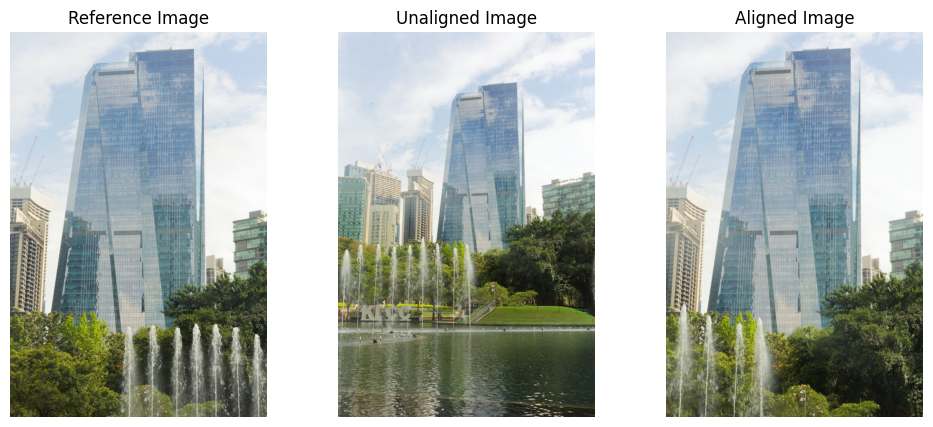

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def read_image(filename):
    """Reads a JPG/PNG image in color (BGR format)."""
    image = cv2.imread(filename)
    if image is None:
        raise ValueError(f"Failed to read image: {filename}")
    return image

def align_images(img1, img2):
    """Aligns img2 to img1 using ORB feature matching and RANSAC."""
    orb = cv2.ORB_create(5000)

    # Convert images to grayscale for feature detection
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Detect keypoints and descriptors
    kp1, des1 = orb.detectAndCompute(img1_gray, None)
    kp2, des2 = orb.detectAndCompute(img2_gray, None)

    # Match features using BFMatcher
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)  # Sort by distance

    # Use RANSAC to find homography
    if len(matches) > 10:
        src_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
        
        H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        
        # Warp img2 to align with img1 (preserving colors)
        aligned_img = cv2.warpPerspective(img2, H, (img1.shape[1], img1.shape[0]))
        
        return aligned_img, H
    else:
        raise ValueError("Not enough matches found.")

# Example usage
DIR = "first-dataset-JPG/"
image1_path = f"{DIR}IMG_7781_DxO.JPG"
image2_path = f"{DIR}IMG_7782_DxO.JPG"  

img1 = read_image(image1_path)
img2 = read_image(image2_path)

aligned_img, homography = align_images(img1, img2)

# Convert BGR to RGB for correct color display in Matplotlib
img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
aligned_img_rgb = cv2.cvtColor(aligned_img, cv2.COLOR_BGR2RGB)

# Show results
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.imshow(img1_rgb)
plt.title("Reference Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img2_rgb)
plt.title("Unaligned Image")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(aligned_img_rgb)
plt.title("Aligned Image")
plt.axis('off')

plt.show()
